# Titanic master
Create core set of examples for use later on
Source: https://www.kaggle.com/sws144/a-data-science-framework-to-achieve-99-accuracy/edit

## Data & Package Prep

In [1]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/titanic'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# For numerical
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print("pandas version: {}". format(pd.__version__))

../input/titanic\gender_submission.csv
../input/titanic\test.csv
../input/titanic\train.csv
pandas version: 0.24.2


In [2]:
# For building models

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier #may need to run pip install xgboost instead of conda

#Common Model Helpers, including hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Statistics
from scipy import stats

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [3]:
# read data
train_data = pd.read_csv("../input/titanic/train.csv")
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Explore Data

In [4]:
# see data live
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# data types
print(train_data.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [6]:
# import test data
test_data  = pd.read_csv("../input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
# correlation by survival
choices = ['Pclass', 'Sex']
for x in choices:
    print('Survival Correlation by:' +  x)
    print(train_data[[x,"Survived"]].groupby(x,as_index=False).mean()) # indexing by 2 columns
    print('-'*10, '\n')

Survival Correlation by:Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by:Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 



## Start Model 1

In [8]:
# consider first model example, using gender == female and explore how that looks in our data
# pull the survival column for women rows
women = train_data.loc[train_data.Sex == 'female']['Survived']
rate_women = sum(women)/len(women)
print( "%4.1f pct  of women survived" % (rate_women * 100.0))

# similarly for men
men = train_data.loc[train_data.Sex == 'male']['Survived']
rate_men = sum(men)/len(men)
print( "%4.1f pct  of men survived" % (rate_men * 100.0))



74.2 pct  of women survived
18.9 pct  of men survived


## Try Model 2 - Tree

In [9]:
# now, try a tree-based model
from sklearn.ensemble import RandomForestClassifier

y = train_data['Survived']

# choose features, as they are classifiers need to get dummy variables
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

tree_model_1 = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 1)
tree_model_1.fit(X,y)
tree_model_1_pred_train =  tree_model_1.predict(X)
tree_model_1_pred_test  = tree_model_1.predict(X_test)

In [10]:
# get training probabilities test
pred_train_prob = RandomForestClassifier.predict_proba(tree_model_1, X)
print("valid classes: " + str(tree_model_1.classes_))
print(pred_train_prob[1:10])

valid classes: [0 1]
[[0.0335568  0.9664432 ]
 [0.38113546 0.61886454]
 [0.0335568  0.9664432 ]
 [0.87982101 0.12017899]
 [0.87982101 0.12017899]
 [0.66537783 0.33462217]
 [0.93840841 0.06159159]
 [0.42461752 0.57538248]
 [0.10668534 0.89331466]]


In [11]:
# evaluate tree based on training data
from sklearn.metrics import confusion_matrix, classification_report
# actual, predictions
print("confusion matrix: \n actual\\predicted \n(0 , 1)")
print(confusion_matrix(y, tree_model_1_pred_train))
print(classification_report(y, tree_model_1_pred_train))

confusion matrix: 
 actual\predicted 
(0 , 1)
[[492  57]
 [107 235]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       549
           1       0.80      0.69      0.74       342

    accuracy                           0.82       891
   macro avg       0.81      0.79      0.80       891
weighted avg       0.82      0.82      0.81       891



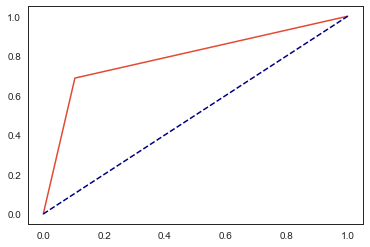

In [12]:
# plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y, tree_model_1_pred_train)

import matplotlib.pyplot as plt 
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.show()

In [13]:
# tune parameters using gridsearchcv

# splitter class
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

# grid to search for params
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

tree_model_1_tuned = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), 
    param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tree_model_1_tuned.fit(X,y)
tree_model_1_tuned_pred_test = tree_model_1_tuned.predict(X_test)


In [14]:
print(stats.describe(tree_model_1_tuned_pred_test))
print(tree_model_1_tuned_pred_test[1:10])

DescribeResult(nobs=418, minmax=(0, 1), mean=0.35167464114832536, variance=0.22854634952325223, skewness=0.621267123965392, kurtosis=-1.6140271606797705)
[1 0 0 1 0 1 0 1 0]


## Try Multiple Models at a Time

In [15]:
# Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier()
]

## Predict Based on Chosen Model

In [16]:
# select predictions
predictions = tree_model_1_tuned_pred_test

In [17]:
# save results
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
